In [1]:
%matplotlib inline

from datetime import datetime
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt

import os, json, math, pprint
import glob, datetime, ast, pytz

In [2]:
def load_all_files(path ='processed_nw_data/'):
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    return frame

In [3]:
frame = load_all_files()
frame['user_id'] = frame['Unnamed: 0']
frame['hour'] = frame.timestamp.apply(lambda x : datetime.datetime.fromtimestamp(x).hour)
frame['year_month_index'] = frame.timestamp.apply(lambda x : 12 * ((datetime.datetime.fromtimestamp(x).year) - 2008 ) + (datetime.datetime.fromtimestamp(x).month))

del frame['Unnamed: 0']

frame = frame[['user_id', 'date', 'hour', 'year_month_index', 'lat', 'location_id', 'lon', 'timestamp', 'vector']]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4740254 entries, 0 to 8929
Data columns (total 9 columns):
user_id             int64
date                object
hour                int64
year_month_index    int64
lat                 float64
location_id         object
lon                 float64
timestamp           float64
vector              object
dtypes: float64(3), int64(3), object(3)
memory usage: 361.7+ MB


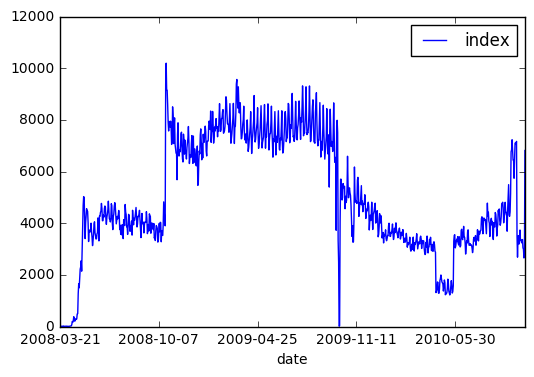

In [4]:
# Movement of dates for all the recordings
dates = frame[['date']].reset_index().groupby(['date']).count().reset_index().sort_values(by=['date'])
dates[['date', 'index']].set_index('date').plot()

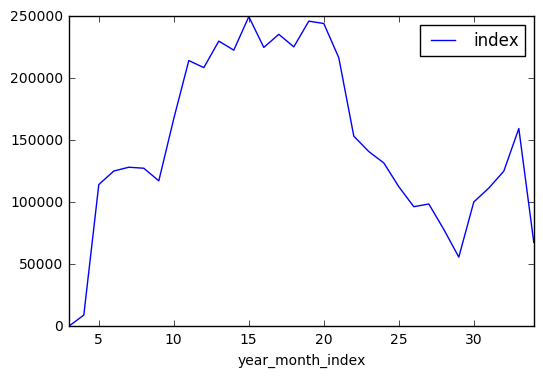

In [5]:
# Movement of month year for all the recordings
dates = frame[['year_month_index']].reset_index().groupby(['year_month_index']).count().reset_index().sort_values(by=['year_month_index'])
dates[['year_month_index', 'index']].set_index('year_month_index').plot()

In [6]:
mask = ((frame['lat'] != 0.0) & (frame['lon'] != 0.0)) 
frame = frame[mask]

In [7]:
mask = frame['vector'] != '[]'
frame = frame[mask]

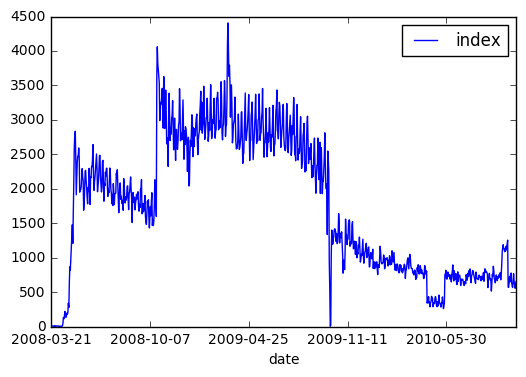

In [8]:
# Movement of dates for filtered recordings
dates = frame[['date']].reset_index().groupby(['date']).count().reset_index().sort_values(by=['date'])
dates[['date', 'index']].set_index('date').plot()

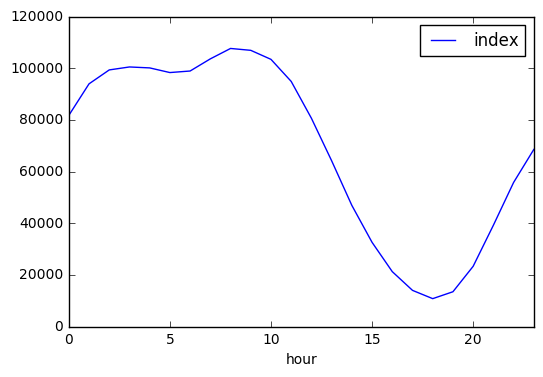

In [9]:
dates = frame[['hour']].reset_index().groupby(['hour']).count().reset_index().sort_values(by=['hour'])
dates[['hour', 'index']].set_index('hour').plot()

In [10]:
frame['vector'] = frame.vector.apply(lambda x : ast.literal_eval(x))

In [32]:
def get_amenity(row):
    for elem in row:
        elem = ast.literal_eval(elem)        
        distance = elem['distance']
        address = ast.literal_eval(elem['address'])

        for item in address:
            item = item.split(":")
            if item[0] == 'amenity':
                return (item[1], distance)
    return None

def get_shop(row):
    for elem in row:
        elem = ast.literal_eval(elem)
        distance = elem['distance']
        address = ast.literal_eval(elem['address'])
        for item in address:
            item = item.split(":")
            if item[0] == 'shop':
                return (item[1], distance)
    return None


def get_highway(row):
    for elem in row:
        elem = ast.literal_eval(elem)
        distance = elem['distance']
        address = ast.literal_eval(elem['address'])
        for item in address:
            item = item.split(":")
            if item[0] == 'highway':
                return (item[1], distance)
    return None

def get_city(row):
    for elem in row:
        elem = ast.literal_eval(elem)
        distance = elem['distance']
        address = ast.literal_eval(elem['address'])
        for item in address:
            tmp = item.split(":")
            if tmp[0] == 'city':
                return tmp[1]
            
            tmp = item.split(":city:")
            if len(tmp) > 1:
                return tmp[1]
        return None

In [12]:
frame['amenity'] = frame.vector.apply(lambda x : get_amenity(x))
frame['highway'] = frame.vector.apply(lambda x : get_highway(x))
frame['shop'] = frame.vector.apply(lambda x : get_shop(x))

In [33]:
frame['city'] = frame.vector.apply(lambda x : get_city(x))

In [27]:
frame.to_pickle('data_map.pickle')

In [28]:
frame = pd.read_pickle('data_map.pickle')

In [34]:
frame[['timestamp', 'date', 'hour', 'amenity', 'shop' , 'highway' , 'city']] .sort_values('timestamp').head(10)

,timestamp,date,hour,amenity,shop,highway,city
13651,1.206132e+09,2008-03-21,4,"(bicycle_parking, 38.65392592025194)",None,"(bus_stop, 20.61826175982727)",None
4110,1.206162e+09,2008-03-22,13,None,None,"(crossing, 49.5650030709591)",None
24251,1.206165e+09,2008-03-22,13,None,None,"(crossing, 8.844271320365996)",None
24250,1.206167e+09,2008-03-22,14,None,None,"(crossing, 8.844271320365996)",None
24252,1.206168e+09,2008-03-22,14,None,None,"(crossing, 8.844271320365996)",None
12393,1.206236e+09,2008-03-23,9,"(restaurant, 27.76583710166927)",None,"(crossing, 9.311894057913076)",None
12399,1.206236e+09,2008-03-23,9,"(restaurant, 27.76583710166927)",None,"(crossing, 9.311894057913076)",None
12392,1.206240e+09,2008-03-23,10,"(restaurant, 27.76583710166927)",None,"(crossing, 9.311894057913076)",None
34537,1.206244e+09,2008-03-23,11,"(bar, 17.014269592590757)","(coffee, 15.794467555161892)","(traffic_signals, 13.111565062445047)",None
34536,1.206247e+09,2008-03-23,12,"(bar, 17.014269592590757)","(coffee, 15.794467555161892)","(traffic_signals, 13.111565062445047)",None


In [35]:
frame[['city']].drop_duplicates()

,city
0,None
213,New York
231,San Francisco
590,Encinitas
654,Denver
1153,Palo Alto
1327,City of Brantford
1407,Solana Beach
1699,Berkeley
1737,St. Louis


In [42]:
tmp_series  =  frame.dropna().shop.apply(lambda x : x[1])
# frame.distance_a.hist()

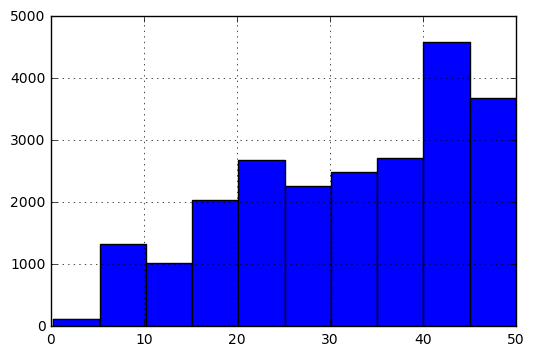

In [43]:
tmp_series.hist()